In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(precision=3)
%precision 3
start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(window=[5,3])
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_53_vecDim100
processing data...
Found  1298  training entries.
Found  1298  cleaned entries.
/home/franzi/Documents/data/vectors_win5-3.npy
0 []
window [5, 3]
window [5, 3]
36942 36942 11756 11756 0 0
took:  608.5526268482208


In [ ]:
import numpy as np
label_y = prepare_training_data.one_hot_to_labels(y_train)

In [4]:
from tensorflow.keras import *

In [5]:
# Build the model
print('Build model...')
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(256))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.Dense(units=len(labels)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=64
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

2020-08-31 15:26:48 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
Train on 36942 samples, validate on 11756 samples


2020-08-31 15:26:52 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
36942/36942 [==============================] - 153s 4ms/sample - loss: 0.9046 - acc: 0.6674 - val_loss: 0.7244 - val_acc: 0.7354
Epoch 2/5
36942/36942 [==============================] - 140s 4ms/sample - loss: 0.5844 - acc: 0.7853 - val_loss: 0.5828 - val_acc: 0.7987
Epoch 3/5
36942/36942 [==============================] - 148s 4ms/sample - loss: 0.4930 - acc: 0.8256 - val_loss: 0.4861 - val_acc: 0.8300
Epoch 4/5
36942/36942 [==============================] - 151s 4ms/sample - loss: 0.4479 - acc: 0.8426 - val_loss: 0.4723 - val_acc: 0.8357
Epoch 5/5
36942/36942 [==============================] - 140s 4ms/sample - loss: 0.4120 - acc: 0.8564 - val_loss: 0.4677 - val_acc: 0.8425


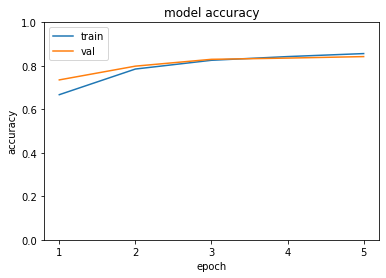

In [6]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
# predict test data
y_pred = model.predict(x_test)

In [8]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

print('class distribution test data + predicted')
print('-----------------------------------')
for i, label in enumerate(labels):
    print(i,label,':',np.sum(true_label==i), 'pred: ',np.sum(pred_label==i))

class distribution test data + predicted
-----------------------------------
0 Ausbildung : 540 pred:  547
1 Beruf : 62 pred:  7
2 allgemein : 717 pred:  547
3 berufsspez : 1057 pred:  1137
4 Sprache : 221 pred:  218
5 Technologie : 755 pred:  902
6 Softskill : 1073 pred:  1359
7 noSkill : 7331 pred:  7039


In [9]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |     Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+-----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.837294 | 0.857143  |    0.508227 |     0.615655 |  0.949541 |      0.730599 |    0.728477 |  0.938628 |
| recall    |     0.848148 | 0.0967742 |    0.387727 |     0.662252 |  0.936652 |      0.872848 |    0.922647 |  0.901241 |
| f1        |     0.842686 | 0.173913  |    0.439873 |     0.638104 |  0.943052 |      0.795413 |    0.814145 |  0.919555 |
f1 average:  0.6958427284467799
f1 average:  0.6173558013463506
Precision average:  0.7706954418961945
recall average:  0.7035359988368737
acc 0.8425484858795509


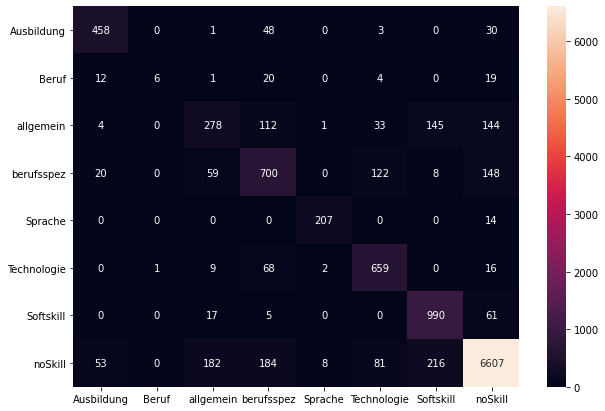

In [10]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [11]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6607


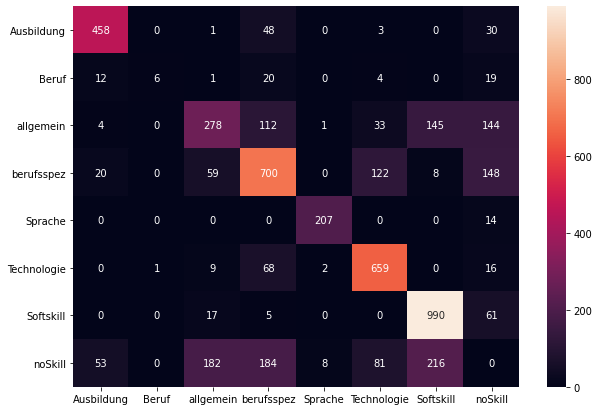

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [13]:
from word2vec import W2V#get_closest_word_to_vec_matrix
correct = []
false = []

clean_x_test, pred_label, true_label, afks = shuffle(clean_x_test, pred_label, true_label, afks,random_state=0)
skill_index = int(len(clean_x_test[0])/2)
label_list = list(labels.keys())


In [14]:
headers = [['|']+[l] for l in label_list ]
headers = sum(headers, [])
headers.append('|')

wvs = []
for i in range(len(clean_x_test)):
    wvs.append(clean_x_test[i][skill_index])

w2v = W2V(skipgram=True, punctuation_marks=False, stoppwords=False, multiword=False, lower_case=False, vector_dim=100

predictions = [[],[],[],[],[],[],[], []]
for i in range(len(clean_x_test)):
    word = w2v.get_closest_word_to_vec(wvs[i])[0][0]
    label = str(true_label[i])
    predictions[pred_label[i]].append(word + '('+label+')')

table = []
# format
i = 0
while(i < len(predictions[0]) or i < len(predictions[1]) or i < len(predictions[2]) or i < len(predictions[3]) or i < len(predictions[4]) or i < len(predictions[5] or i < len(predictions[6]))):
    row = ['|']
    for x in predictions:
        if(len(x) > i and len(x[i]) <  25): 
            row.append(x[i])
            row.append('|')
        else:
            row.append('')
            row.append('|')
            
    table.append(row)
    i+=1    

print(tabulate(table, headers=headers))

skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
|    Ausbildung                |    Beruf         |    allgemein                 |    berufsspez                |    Sprache                  |    Technologie               |    Softskill                 |    noSkill                   |
---  ------------------------  ---  ------------  ---  ------------------------  ---  ------------------------  ---  -----------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---
|    Ausbildung(0)             |    Team(1)       |    begabt(7)                 |    Vorteil(3)                |                             |    Erfahrung(5)              |                              |    Berufserfahrung(3)   